### Article's Code
You can find it in <a href='https://github.com/wuningxi/tBERT'>this</a> Github.


### Prerequisites:

In [1]:
!pip install --quiet transformers

     |████████████████████████████████| 4.7 MB 8.3 MB/s 
     |████████████████████████████████| 596 kB 76.3 MB/s 
     |████████████████████████████████| 6.6 MB 69.6 MB/s 
     |████████████████████████████████| 101 kB 10.0 MB/s 


### Imports:

In [2]:
import gc
import random
import warnings


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


import torch
from torch import nn
import torch.optim as optim
from torch.cuda import empty_cache
from torch.utils.data import DataLoader, random_split


from transformers import logging
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
from transformers import BertModel,BertTokenizer
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available


from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report

from sklearn.utils import compute_class_weight
from tqdm import tqdm

import gensim, spacy
import gensim.corpora as corpora
from nltk.corpus import stopwords

import pandas as pd
import re
from tqdm import tqdm
import time

from collections import defaultdict
from google.colab import drive

##### Warnings & Verbose

In [3]:
warnings.filterwarnings("ignore") # general
logging.set_verbosity_error() # huggingface

##### Setup -  Natural Language Tool Kit 

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##### Setup - Google Drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/NLP/tBert-final-project/tBERT/

/content/drive/MyDrive/NLP/tBert-final-project/tBERT


In [7]:
!ls

Code_Article_Torch_Original.ipynb
data
gensim-lda.ipynb
lda_bert.ipynb
lda_cv.ipynb
results
Sentiment_Analysis_and_Topic_Modelling_on_Brand-Related_Social_Media_Data.pdf
tBERT.jpg
tBERT_with_GSDMM.ipynb
tBERT_with_LDA.ipynb
tBERT_with_LDA_QOURA.ipynb


In [8]:
SEED = 82

In [9]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(SEED)

## Dataset

##### Torch's Dataset

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        return x,y

    def __len__(self):
        return len(self.encodings)


class PairDataset(torch.utils.data.Dataset):
    def __init__(self, text1,text2,labels):
        self.text1  = text1
        self.text2  = text2
        self.labels = labels

    def __getitem__(self, idx):
        x1 = self.text1[idx]
        x2 = self.text2[idx]
        y = self.labels[idx]
        return x1,x2,y

    def __len__(self):
        return len(self.labels)

### QUORA


In [11]:
quora_train = 'data/Quora/Quora_question_pair_partition/train.tsv'
quora_val   = 'data/Quora/Quora_question_pair_partition/dev.tsv'
quora_test  = 'data/Quora/Quora_question_pair_partition/test.tsv'

##### Create a dataframe

In [12]:
df_quora_train = pd.read_csv(quora_train, sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1','q2', 'id'],usecols=[0,1,2]).dropna()
df_quora_val   = pd.read_csv(quora_val,   sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1','q2', 'id'],usecols=[0,1,2]).dropna()
df_quora_test  = pd.read_csv(quora_test,  sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1','q2', 'id'],usecols=[0,1,2]).dropna()

df_quora_train.shape,df_quora_val.shape,df_quora_test.shape


((384345, 3), (9999, 3), (9999, 3))

In [13]:
df_quora_train.head()

,label,q1,q2
0,0,"Currently , all Supreme Court Justices come fr...",What 's your type of jungle -LRB- concrete or ...
1,1,Why is saltwater taffy candy imported in Austr...,Why is salt water taffy candy unknown in Japan ?
2,0,"Who has the better stable of characters , DC o...",Which is better - DC or Marvel ?
3,1,What is difference between CAT and GMAT in ter...,What is the difference between the CAT and GMA...
4,0,How can I stop being addicted to love ?,How can I stop being so addicted to my phone ?


In [14]:
df_quora_test.head()

,label,q1,q2
0,0,Do women support each other more than men do ?,Do women need more compliments than men ?
1,1,How can one root android devices ?,How do I root an Android device ?
2,0,How did Hitler come to power ?,Who followed Hitler to power ?
3,1,Can we donate blood after getting a tattoo ?,Can I donate blood if I have a tattoo ?
4,0,What are reviews for the BioVault 2.0 Biometri...,Do you need a safe for a long gun in California ?


##### Create PairDataset

In [15]:
dataset_quora_train = PairDataset(df_quora_train.q1.values, df_quora_train.q2.values, df_quora_train.label.values)
dataset_quora_val   = PairDataset(df_quora_val.q1.values,   df_quora_val.q2.values,   df_quora_val.label.values)
dataset_quora_test  = PairDataset(df_quora_test.q1.values,  df_quora_test.q2.values,  df_quora_test.label.values)

##### Distribution - Traget Labels  


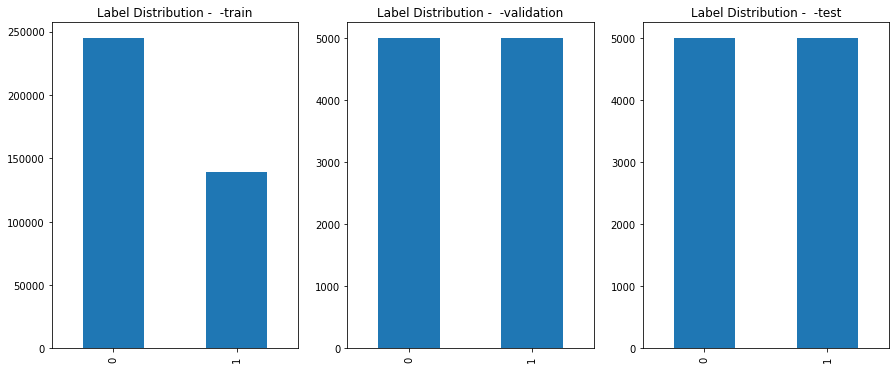

In [16]:
d = {'train':df_quora_train,'validation':df_quora_val,'test':df_quora_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution -  -' + k)

It is easy to see that there are twise as much "true" then "false" - as it was proposed in the article, will use the F1 parameter to evaluate our resulted model. In addition the quora dataset is very big, let us play with the size of the dataset. I will use this smaller sample to work through your problem before fitting a final model on all of your data (using progressive data loading techniques). It is a good practice in general for machine learning to give you quick spot-checks of algorithms and turnaround of results.
<br><br>

In [17]:
df_quora_train = df_quora_train.sample(frac=0.05, random_state=SEED)
df_quora_val = df_quora_val.sample(frac=0.10, random_state=SEED)
df_quora_test = df_quora_test.sample(frac=0.10, random_state=SEED)

In [18]:
dataset_quora_train = PairDataset(df_quora_train.q1.values, df_quora_train.q2.values, df_quora_train.label.values)
dataset_quora_val   = PairDataset(df_quora_val.q1.values,   df_quora_val.q2.values,   df_quora_val.label.values)
dataset_quora_test  = PairDataset(df_quora_test.q1.values,  df_quora_test.q2.values,  df_quora_test.label.values)

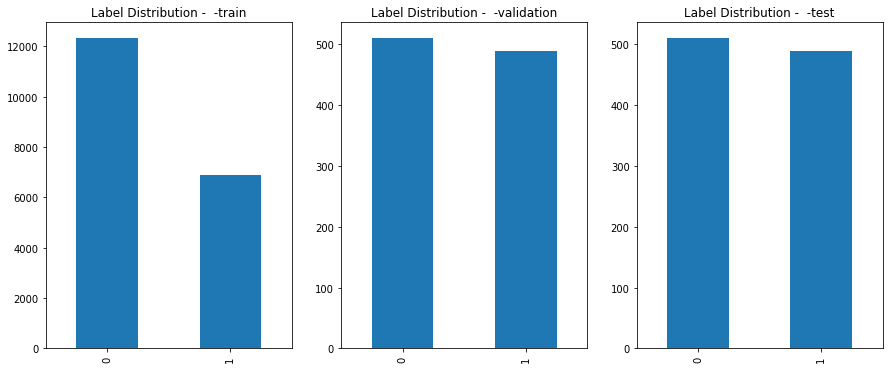

In [19]:
d = {'train':df_quora_train,'validation':df_quora_val,'test':df_quora_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution -  -' + k)

## Models - Setup DL models

#### Model - BERT


























































































































































































#### Setup Trainer

In [20]:
T_SEED=SEED

In [21]:
T_MAX_LEN = 10

In [22]:
MAX_LEN_BERT = 50

In [23]:
n_topics = [1,5,10,20,60,70,75,80,85,90,100]

In [24]:
# BERT_MODEL_NAME = "google/bert_uncased_L-12_H-768_A-12"
BERT_MODEL_NAME = "bert-base-uncased"

In [25]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [26]:
def preprocessing(sentence):
  sentence = str(sentence).lower()                                            # lower latters
  words = word_tokenize(sentence)                                             # split into words
  words = [word for word in words if word.isalpha()]                          # remove punctuations
  words = [word for word in words if word not in stopwords.words('english')]  # remove stopwords
  words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2] == 'NN']    # keep nouns
  sentence = ' '.join(words)                                                  # combine words to a sentence
  return sentence
def preprocessAll(sentences):
  sentences = [preprocessing(sentence) for sentence in sentences]
  return sentences

def get_words_len_for_topics(topics):
  return 50

In [27]:
all_sentences = df_quora_train.q1.values.tolist()
all_sentences.extend(df_quora_train.q2.values.tolist())
all_sentences.extend(df_quora_val.q1.values.tolist())
all_sentences.extend(df_quora_val.q2.values.tolist())
# all_sentences = list(set(all_sentences))  
# all_sentences = preprocessAll(all_sentences)

In [28]:
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = stopwords.words('english')
# Add some extra words in it if required
stop_words.extend(['from', 'subject', 'use','pron'])

In [29]:
def clean_procedure(input_data):
  data = input_data

  ### Cleaning data

  # Remove Emails
  data = [re.sub('S*@S*s?', '', sent) for sent in data]
  # Remove new line characters and extra space
  data = [re.sub('s+', ' ', sent) for sent in data]
  # Remove single quotes
  data = [re.sub("'", "", sent) for sent in data]

  ### Lemmatization
  data_lemma = []
  for i, txt in enumerate(data):
      lis = []
      doc = nlp(txt)
      for token in doc:
          lis.append(token.lemma_)
      data_lemma.append(' '.join(lis))

  ### Tokenization and gensim stopword removal

  # You can look for all gensim stopwords by running -> 'gensim.parsing.preprocessing.STOPWORDS'

  # Function to tokenize
  # Also remove words whose length less than 3 (you can chang it)
  def tokenization_with_gen_stop(text):
      result=[]
      for token in gensim.utils.simple_preprocess(text) :
          if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
              result.append(token)

      return result

  ## Apply tokenization function
  data_words = []
  for i, txt in enumerate(data_lemma):
      data_words.append(tokenization_with_gen_stop(txt))

  ### NLTK Stopword removal (extra stopwords)

  _cleaned = []
  for i, word in enumerate(data_words):
      wrd = []
      for w in word:
          if w not in stop_words:
              wrd.append(w)
      _cleaned.append(wrd)
  mapped = dict()
  for i, words in enumerate(_cleaned):
    mapped[input_data[i]] = words
  return _cleaned, mapped

In [30]:
print('cleaning data...')
data_words_clean, mapped = clean_procedure(all_sentences)
# Create Dictionary
dictionary = corpora.Dictionary(data_words_clean)
# Print dictionary
print(dictionary.token2id)

## Create Term document frequency (corpus)
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in data_words_clean]

cleaning data...
{'hire': 0, 'ional': 1, 'kill': 2, 'painter': 3, 'profe': 4, 'sydney': 5, 'kanniyakumari': 6, 'near': 7, 'place': 8, 'touri': 9, 'filing': 10, 'income': 11, 'properti': 12, 'return': 13, 'briti': 14, 'enior': 15, 'equivalent': 16, 'hman': 17, 'junior': 18, 'inve': 19, 'long': 20, 'mart': 21, 'sail': 22, 'term': 23, 'tment': 24, 'tock': 25, 'email': 26, 'omeone': 27, 'politely': 28, 'reply': 29, 'certificate': 30, 'europe': 31, 'hould': 32, 'obtain': 33, 'order': 34, 'relevant': 35, 'technical': 36, 'upport': 37, 'work': 38, 'countrie': 39, 'difficult': 40, 'earn': 41, 'banking': 42, 'erie': 43, 'exam': 44, 'online': 45, 'feedback': 46, 'quora': 47, 'ubmit': 48, 'extend': 49, 'functionality': 50, 'kera': 51, 'plan': 52, 'hard': 53, 'client': 54, 'cognizant': 55, 'major': 56, 'solution': 57, 'technology': 58, 'ntse': 59, 'prepare': 60, 'becau': 61, 'contend': 62, 'conway': 63, 'gender': 64, 'hillary': 65, 'inten': 66, 'kellyanne': 67, 'male': 68, 'white': 69, 'foreign': 

In [31]:
class LDA_Wrapper_Topics_Distributions_Gensim:
    def __init__(self, random_seed, data_words_clean, map_for_train, corpus, dictionary, n_components=10):
      self.seed = random_seed
      self.map_for_train=map_for_train
      self.data_words_clean = data_words_clean
      self.corpus = corpus
      self.dictionary = dictionary
      self.n_components = n_components
      self.ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=self.n_components, 
                                           passes=15,
                                           alpha='auto',
                                           random_state=random_seed,
                                           minimum_probability = 0.00000001)

      # Saving trained model
      self.ldamodel.save(f'results/LDA_{self.n_components}')
      # Loading trained model
      self.ldamodel = gensim.models.ldamodel.LdaModel.load(f'results/LDA_{self.n_components}')
      self.max_len = n_components
      self.log_lines = []
      self.print=self.__print_log__

    def __print_log__(self, x):
      pass

    def topic_distribution_by_topic_order(self, string_input):
      # Fit and transform
      bow = self.ldamodel.id2word.doc2bow(string_input) # convert to bag of words format first
      # print(bow)
      doc_topics, word_topics, phi_values = self.ldamodel.get_document_topics(bow, per_word_topics=True)
      # print(doc_topics)
      # Convert sparse matrix to gensim corpus.
      # corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

      output = [topic[1] for topic in doc_topics]    
      return output

    def transform(self, sentences):
      p = []
      for sentence in sentences:
        clean_sentence = self.map_for_train[sentence]
        # print(sentence)
        # print(clean_sentence)
        dists = self.topic_distribution_by_topic_order(clean_sentence)
        p.append(dists)
      # print(f'{len(p)}x{len(p[0])}')
      # print(p)
      # raise Exception('debug')
      self.print("in transform")
      # print(p.shape)
      # print(p)
      return torch.tensor(p).type(torch.FloatTensor);

    def transform_cleaned(self, sentences):
      p = []
      for clean_sentence in sentences:
        # print(sentence)
        # print(clean_sentence)
        dists = self.topic_distribution_by_topic_order(clean_sentence)
        p.append(dists)
      # print(f'{len(p)}x{len(p[0])}')
      # print(p)
      # raise Exception('debug')
      self.print("in transform")
      # print(p.shape)
      # print(p)
      return torch.tensor(p).type(torch.FloatTensor);

    def evaluate_model(self):
      # Compute Perplexity Score
      print('nPerplexity Score: ', self.ldamodel.log_perplexity(self.corpus))

      # Compute Coherence Score
      coherence_model_lda = gensim.models.CoherenceModel(model=self.ldamodel, texts=self.data_words_clean, dictionary=self.dictionary, coherence='c_v')
      coherence_lda = coherence_model_lda.get_coherence()
      print('nCoherence Score: ', coherence_lda)

In [55]:
topics_dict_gensim = dict()
print(f'ceating topic generators')
# n_topics
for n in [85, 90]:
  set_seed(SEED)
  topics_dict_gensim[n] = LDA_Wrapper_Topics_Distributions_Gensim(T_SEED, data_words_clean, mapped, corpus, dictionary, n_components=n)
  topics_dict_gensim[n].evaluate_model()
  print(f'ceated topic generator for {n} topics')

ceating topic generators
nPerplexity Score:  -27.095570738309394
nCoherence Score:  0.6301380056122527
ceated topic generator for 85 topics
nPerplexity Score:  -28.374383315894217
nCoherence Score:  0.6234371786198701
ceated topic generator for 90 topics


In [56]:
topics_dict = topics_dict_gensim

In [57]:
BATCH_SIZE = 32

In [58]:
from transformers import AdamW
class myTrainer():
  def __init__(self,
               model,
               train_dataset, val_dataset,test_dataset,
               batch_size,
               epochs = 5, with_LDA = True, model_name = 'basemodel'):
    
    self.model = model
    self.epochs = epochs
    self.with_LDA = with_LDA
    self.model_name = str(model_name)

    weights_train = compute_class_weight(class_weight='balanced', classes= np.unique(train_dataset.labels), y=train_dataset.labels)
    self.weights_train = torch.tensor(weights_train).type(torch.FloatTensor).cuda()
    weights_val = compute_class_weight(class_weight='balanced', classes= np.unique(val_dataset.labels), y=val_dataset.labels)
    self.weights_val = torch.tensor(weights_val).type(torch.FloatTensor).cuda()
    weights_test = compute_class_weight(class_weight='balanced', classes= np.unique(test_dataset.labels), y=test_dataset.labels)
    self.weights_test = torch.tensor(weights_test).type(torch.FloatTensor).cuda()

    self.criterion = nn.BCELoss()
    learningRate = 50 ** -5
    self.optimizer = AdamW(self.model.parameters(), lr=learningRate)
    self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    self.test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    self.loss_train = []
    self.loss_val = []

  def calculate_loss(self, true_y, predicted_y):
    label_tensor = true_y.type(torch.FloatTensor).unsqueeze(1).cuda()
    loss = self.criterion(predicted_y, label_tensor)
    return loss



  def train(self):
    min_valid_loss = np.inf
    
    # run on all epochs
    print(self.model_name + ': Training \t',end='')
    print('\n')
    for epoch in range(self.epochs):
      with tqdm(self.train_dataloader, unit="batch", leave=False) as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch+1} train step")
            if len(data)==3:
              self.train_loss_pair(data)
            else:
              self.train_loss(data)

      with tqdm(self.val_dataloader, unit="batch", leave=False) as vepoch:
        for data in vepoch:
            vepoch.set_description(f"Epoch {epoch+1} validation step")
            if len(data)==3:
              self.val_loss_pair(data)
            else:
              self.val_loss(data)
      # # print()

      # # train
      # for data in self.train_dataloader:
      #   print('.',end='')

      #   if len(data)==3:
      #     self.train_loss_pair(data)
      #   else:
      #     self.train_loss(data)
      # # eval      
      # self.model.eval()     # Optional when not using Model Specific layer
      # for data in self.val_dataloader:
      #   if len(data)==3:
      #     self.val_loss_pair(data)
      #   else:
      #     self.val_loss(data)
      # # print progress
      # # print(f'Epoch {e+1} \t\t Training Loss: {self.loss_train[-1] / len(self.train_dataloader)} \t\t Validation Loss: {self.loss_val[-1] / len(self.val_dataloader)}')

      # # save the optimal model    
      if min_valid_loss > self.loss_val[-1]:
          # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{self.loss_val[-1]:.6f})')
          min_valid_loss = self.loss_val[-1]
          self.save_model()
    # load best model
    self.load_model()      
    

  def train_loss(self,data):
    inputs, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs)  #.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # tokens_lda = self.model.tokenizing(inputs)
      features_lda = self.model.model_lda.transform(inputs)
      features_lda = features_lda.cuda()

      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
      
    # Find the Loss
    loss = self.calculate_loss(labels, target)

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def train_loss_pair(self,data):
    inputs1, inputs2, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # inputs1
      # tokens_lda1 = self.model.tokenizing(inputs1)
      # print("get topics")
      features_lda1 = self.model.model_lda.transform(inputs1)
      # print(features_lda1)
      # inputs2
      # tokens_lda2 = self.model.tokenizing(inputs2)
      features_lda2 = self.model.model_lda.transform(inputs2)
      # print(features_lda2)
      features_lda = torch.cat([features_lda1, features_lda2],dim=1)
      features_lda = features_lda.cuda()
      # print("get topics done")
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    # Find the Loss
    # print('labels')
    loss = self.calculate_loss(labels, target)
    # print('loss')
    # print(labels.size())
    
    
    # print('loss done')

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def val_loss(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs) #self.model.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # tokens_lda = self.model.tokenizing(inputs)
      features_lda = self.model.model_lda.transform(inputs)
      features_lda = features_lda.cuda()      
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.calculate_loss(labels, target)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def val_loss_pair(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs1, inputs2, labels = data

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2) 
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # inputs1
      # tokens_lda1 = self.model.tokenizing(inputs1)
      features_lda1 = self.model.model_lda.transform(inputs1)
      
      # inputs2
      # tokens_lda2 = self.model.tokenizing(inputs2)
      features_lda2 = self.model.model_lda.transform(inputs2)
      
      features_lda = torch.cat([features_lda1, features_lda2],dim=1)
      features_lda = features_lda.cuda()
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.calculate_loss(labels, target)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def predict(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval()  
    with torch.no_grad():
      with tqdm(self.test_dataloader, unit="batch") as test_step:
        for b, data in enumerate(test_step):
          test_step.set_description(f"Batch {b+1} predict")
          inputs, labels = data
          
          # tokenizer
          tokens_bert = self.model.tokenizing(inputs)
          tokens_bert = tokens_bert.cuda()
          
          # LDA
          if self.with_LDA:
            inputs_cleaned, map = clean_procedure(inputs)
            # tokens_lda = self.model.tokenizing(inputs)
            features_lda = self.model.model_lda.transform_cleaned(inputs_cleaned)
            features_lda = features_lda.cuda()
            target = self.model(tokens_bert,features_lda)  
          else:
            target = self.model(tokens_bert)
          # print(target)
          target = target.round()
        predictions.extend(target.cpu().detach()[:,0].tolist())
        real_labels.extend(labels.tolist())
    return real_labels,predictions


  def predict_pair(self):

    # results
    real_labels = []
    predictions = []
    print(self.model_name + ': Testing \t',end='')
    print('\n')
    self.model.eval() 
    with torch.no_grad():
      with tqdm(self.test_dataloader, unit="batch", leave=False) as test_step:
        for b, data in enumerate(test_step):
          test_step.set_description(f"Batch {b+1} predict")
          inputs1, inputs2, labels = data

          # tokenizer
          tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
          tokens_bert = tokens_bert.cuda()

          
          
          # LDA
          if self.with_LDA:
            # tokens_lda1 = self.model.tokenizing(inputs1)
            # print(tokens_lda1)
            inputs_cleaned1, map = clean_procedure(inputs1)
            features_lda1 = self.model.model_lda.transform_cleaned(inputs_cleaned1)
            
            # tokens_lda2 = self.model.tokenizing(inputs2)
            inputs_cleaned2, map = clean_procedure(inputs2)
            features_lda2 = self.model.model_lda.transform_cleaned(inputs_cleaned2)
      
            features_lda = torch.cat([features_lda1, features_lda2],dim=1)
            features_lda = features_lda.cuda()
            target = self.model(tokens_bert,features_lda)  
          else:
            target = self.model(tokens_bert)
          # print(target)
          target = target.round()
          predictions.extend(target.cpu().detach()[:,0].tolist())
          real_labels.extend(labels.tolist())
    return real_labels,predictions


  def save_model(self):
    # print('Saving the model... ',end='')
    with open('results/'+ self.model_name +'.pkl', 'wb') as f:
      pickle.dump(self.model, f, pickle.HIGHEST_PROTOCOL)
    # print('done!')


  def load_model(self):
    # print('Loading the model... ',end='')
    with open('results/'+ self.model_name +'.pkl', 'rb') as f:
      self.model = pickle.load(f)


  def plot_losses(self):
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.plot(self.loss_train)
    plt.title('Train Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss')

    plt.subplot(1,2,2)
    plt.plot(self.loss_val)
    plt.title('Validation Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss');
    

In [59]:
# self.n_components
class TBertImpl(nn.Module):
    def __init__(self, model_name, bert_tokenizer, topic_generator,
                 batch_size, t_max_len, n_components=10,
                 max_len=80, isPair=0):
        super(TBertImpl, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.model_lda = topic_generator
        self.tokenizer_bert = bert_tokenizer
        self.model_bert = BertModel.from_pretrained(model_name)
        n_topic_words_counter = self.model_lda.max_len
        input_len = (768 + (n_topic_words_counter + (isPair * n_topic_words_counter)))
        self.classifier = nn.Sequential(
            nn.Linear(input_len, input_len),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(input_len, 1),
            nn.Sigmoid()
        )
        



    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def tokenizing_pair(self,sentences1,sentences2):
      return self.tokenizer_bert(sentences1,sentences2,return_tensors='pt',add_special_tokens=True,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def freeze_BERT(self):
      for name, param in self.model_bert.named_parameters():
        if 'classifier' not in name: # classifier layer
          param.requires_grad = False
      # for param in self.model_bert.parameters():
      #   param.requires_grad = False

    def forward(self, tokens_bert,features_lda):

        # features
        # print('forward bert')
        features_bert = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]
        # print(features_bert.size())
        # raise Exception('debug')
        # print('forward bert done')
        # concatenate
        # print(type(features_lda))
        # print(features_bert.size())
        # print(features_lda.size())
        features = torch.cat([features_bert, features_lda],dim=1)
        # print(features.size())
        # raise Exception('debug')
        
        # classification
        # print('class')
        outputs = self.classifier(features)
        # print(outputs)
        # raise Exception('Debug')
        # print('class done')
        return outputs

## Train Models

##### Train tBERT - with search over number of topics

In [60]:
test_results_dictionary = defaultdict(lambda: "Not Present")

In [61]:
df = pd.DataFrame(columns=['TopicsNumber','tBERT_F1','Loss_Train','Loss_Val'])

def add_result(topics, real_tbert, pred_tbert, loss_train, loss_val, results_dict):
  results_dict[topics] = (real_tbert, pred_tbert)
  f1_tbert = f1_score(y_true=real_tbert,y_pred=pred_tbert)
  df.loc[len(df)] = [str(topics),f1_tbert,loss_train,loss_val]

# n_topics = [60,70,75,80,85,90,100]
for n in [85, 90]:
  set_seed(SEED)
  # model
  model_tbert = TBertImpl(BERT_MODEL_NAME, tokenizer, topics_dict[n], batch_size=BATCH_SIZE, 
                          t_max_len = T_MAX_LEN, isPair=1,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,
                            model_name='tbert_quora_t'+str(n),
                            train_dataset=dataset_quora_train,
                            val_dataset=dataset_quora_val,
                            test_dataset=dataset_quora_test,
                            batch_size=BATCH_SIZE ,epochs=3)
  trainer_tBERT.train()

  # predict
  real_tbert_quora,pred_tbert_quora = trainer_tBERT.predict_pair()

  # save model results
  add_result(n, real_tbert_quora, pred_tbert_quora,trainer_tBERT.loss_train,trainer_tBERT.loss_val, test_results_dictionary)
  print(f'Done for {n} topics')
  # print(df.tBERT_Accuracy.values)



  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_quora_t85: Training 	



tbert_quora_t85: Testing 	



Done for 85 topics
tbert_quora_t90: Training 	



tbert_quora_t90: Testing 	



Done for 90 topics


## Evaluation

In [62]:
df

,TopicsNumber,tBERT_F1,Loss_Train,Loss_Val
0,85,0.350792,"[2.053604006767273, 2.069005250930786, 2.10501...","[2.1101905703544617, 2.1829283237457275, 2.015..."
1,90,0.657682,"[2.136154890060425, 2.2693578600883484, 2.2862...","[2.20685613155365, 1.9897552728652954, 2.20036..."


In [63]:
real_labels_90 = test_results_dictionary[90][0]
predicted_labels_90 = test_results_dictionary[90][1]
print(classification_report(real_labels_90, predicted_labels_90, target_names=['is not paraphrase', 'is paraphrase']))

                   precision    recall  f1-score   support

is not paraphrase       0.80      0.01      0.02       511
    is paraphrase       0.49      1.00      0.66       489

         accuracy                           0.49      1000
        macro avg       0.65      0.50      0.34      1000
     weighted avg       0.65      0.49      0.33      1000



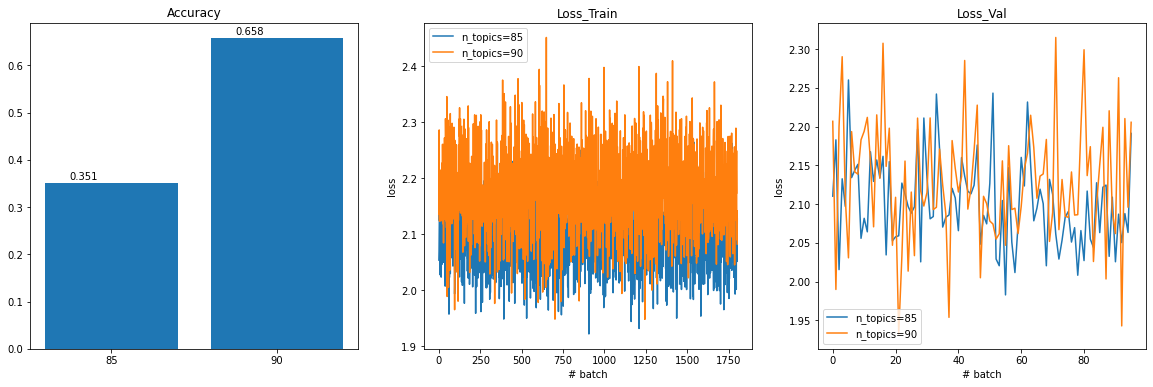

In [64]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.bar(df.TopicsNumber,df.tBERT_F1)
for index,data in enumerate(df.tBERT_F1):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df)):
    y = df[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

The t=90 model performing well as the one in the article.
<br><br><br>

### GSDMM

In [65]:
!pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-0g1ugx4h
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-0g1ugx4h


In [66]:
from gsdmm import MovieGroupProcess

In [67]:
class GSDMM_Wrapper_Topics_Distributions:
    def __init__(self, random_seed, data_words_clean, map_for_train, corpus, dictionary, n_components=10):
      self.seed = random_seed
      self.map_for_train=map_for_train
      self.data_words_clean = data_words_clean
      self.corpus = corpus
      self.dictionary = dictionary
      self.n_components = n_components
      self.gsdmm = MovieGroupProcess(K=self.n_components, alpha=0.1, beta=0.3, n_iters=15)
      self.vocab_length = len(self.dictionary)
      y = self.gsdmm.fit(np.array(data_words_clean), self.vocab_length)
      self.max_len = n_components
      self.log_lines = []
      self.print=self.__print_log__

    def __print_log__(self, x):
      pass

    def transform(self, sentences):
      scores = []
      for sentence in sentences:
        cleaned = self.map_for_train[sentence]
        score = self.gsdmm.score(cleaned)
        scores.append(score)
      return torch.tensor(scores).type(torch.FloatTensor)

    def transform_cleaned(self, sentences):
      scores = []
      for cleaned in sentences:
        score = self.gsdmm.score(cleaned)
        scores.append(score)
      return torch.tensor(scores).type(torch.FloatTensor)

    def evaluate_model(self):
      pass

In [68]:
topics_dict_gensim = dict()
print(f'ceating topic generators')
# n_topics
for n in [85,90]:
  set_seed(SEED)
  topics_dict_gensim[n] = GSDMM_Wrapper_Topics_Distributions(T_SEED, data_words_clean, mapped, corpus, dictionary, n_components=n)
  topics_dict_gensim[n].evaluate_model()
  print(f'ceated topic generator for {n} topics')

ceating topic generators
In stage 0: transferred 38911 clusters with 85 clusters populated
In stage 1: transferred 31940 clusters with 85 clusters populated
In stage 2: transferred 22956 clusters with 85 clusters populated
In stage 3: transferred 17194 clusters with 79 clusters populated
In stage 4: transferred 14073 clusters with 70 clusters populated
In stage 5: transferred 12806 clusters with 60 clusters populated
In stage 6: transferred 11655 clusters with 50 clusters populated
In stage 7: transferred 11026 clusters with 45 clusters populated
In stage 8: transferred 10483 clusters with 46 clusters populated
In stage 9: transferred 10222 clusters with 43 clusters populated
In stage 10: transferred 10034 clusters with 40 clusters populated
In stage 11: transferred 9723 clusters with 38 clusters populated
In stage 12: transferred 9751 clusters with 40 clusters populated
In stage 13: transferred 9645 clusters with 39 clusters populated
In stage 14: transferred 9510 clusters with 37 clu

In [69]:
topics_dict = topics_dict_gensim

In [71]:
test_results_dictionary_GSDMM = defaultdict(lambda: "Not Present")

In [72]:
df_GSDMM = pd.DataFrame(columns=['TopicsNumber','tBERT_F1','Loss_Train','Loss_Val'])

def add_result(topics, real_tbert, pred_tbert, loss_train, loss_val, results_dict):
  results_dict[topics] = (real_tbert, pred_tbert)
  f1_tbert = f1_score(y_true=real_tbert,y_pred=pred_tbert)
  df_GSDMM.loc[len(df_GSDMM)] = [str(topics),f1_tbert,loss_train,loss_val]

# n_topics = [60,70,75,80,85,90,100]
for n in [85,90]:
  set_seed(SEED)
  # model
  model_tbert = TBertImpl(BERT_MODEL_NAME, tokenizer, topics_dict[n], batch_size=BATCH_SIZE, 
                          t_max_len = T_MAX_LEN, isPair=1,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,
                            model_name='tbert_quora_t'+str(n),
                            train_dataset=dataset_quora_train,
                            val_dataset=dataset_quora_val,
                            test_dataset=dataset_quora_test,
                            batch_size=BATCH_SIZE ,epochs=3)
  trainer_tBERT.train()

  # predict
  real_tbert_quora,pred_tbert_quora = trainer_tBERT.predict_pair()

  # save model results
  add_result(n, real_tbert_quora, pred_tbert_quora,trainer_tBERT.loss_train,trainer_tBERT.loss_val, test_results_dictionary_GSDMM)
  print(f'Done for {n} topics')
  # print(df.tBERT_Accuracy.values)



  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_quora_t85: Training 	



tbert_quora_t85: Testing 	



Done for 85 topics
tbert_quora_t90: Training 	



tbert_quora_t90: Testing 	



Done for 90 topics


In [73]:
df_GSDMM

,TopicsNumber,tBERT_F1,Loss_Train,Loss_Val
0,85,0.313376,"[2.0544222593307495, 2.072833836078644, 2.1074...","[2.1075607538223267, 2.187228798866272, 2.0255..."
1,90,0.657682,"[2.1337838172912598, 2.264770209789276, 2.2779...","[2.2026607990264893, 1.9915755987167358, 2.211..."


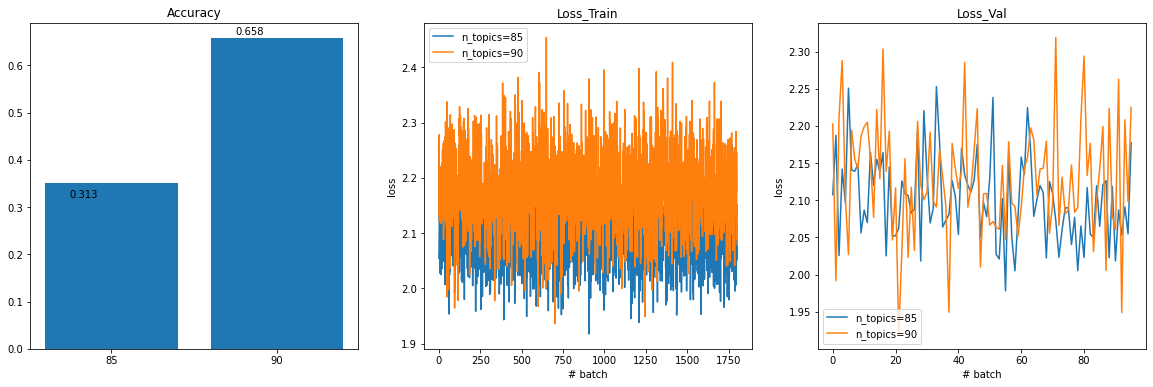

In [74]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.bar(df_GSDMM.TopicsNumber,df.tBERT_F1)
for index,data in enumerate(df_GSDMM.tBERT_F1):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df_GSDMM)):
    y = df_GSDMM[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df_GSDMM.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()